<a href="https://colab.research.google.com/github/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P1_2_HW1_Diffusion_HF_API_standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: реализация модели latent diffusion

## Интро
На семинарах мы познакомились с тем, как обучать диффузионную модель. Эти модели были реализованы через пиксельную диффузию, которую на практике уже никто не использует, потому что это вычислительно сложно обучить. На семинарах было разобрано обучение диффузионной модели. Для обучения вам предлагается обучение модели на датасете `nelorth/oxford-flowers` (https://huggingface.co/datasets/nelorth/oxford-flowers)  

## Цель домашнего задания
Научиться реализовать модель диффузии, модель скрытой диффузии и вносить в нее модификации.


- Часть 1.1 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P1.1_HW1_Diffusion_model_simplified.ipynb)
- Часть 2 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P2_HW_Stable_diff_finetune.ipynb)
- Часть 3 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P3_HW1_Schedulers_inference_steps_comparison.ipynb)



### [5 баллов] Реализация обучения диффузионной модели на новом датасете

В этой части задания вам рекомендуется взять код с семинара и адаптировать его под обучение на новом датасете.

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели и код обучения модели.

# План решения

В качестве 2-го шага я попробую построить обучить модель UNET  c API библиотеки Hugging Face.

В качестве основы возьму код из следующих источников:

- https://huggingface.co/docs/diffusers/tutorials/basic_training


## 1. Подгрузим и преобразуем датасет

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
raw_datasets = load_dataset("nelorth/oxford-flowers")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7169
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1020
    })
})

In [ ]:
from datasets import concatenate_datasets
dataset = concatenate_datasets([raw_datasets['train'], raw_datasets['test']])
dataset = dataset.remove_columns('label')
dataset

Dataset({
    features: ['image'],
    num_rows: 8189
})

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 3


config = TrainingConfig()

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

data_transforms = [
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
]
data_transform = transforms.Compose(data_transforms)

In [ ]:
def transform(examples):
    images = [data_transform(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

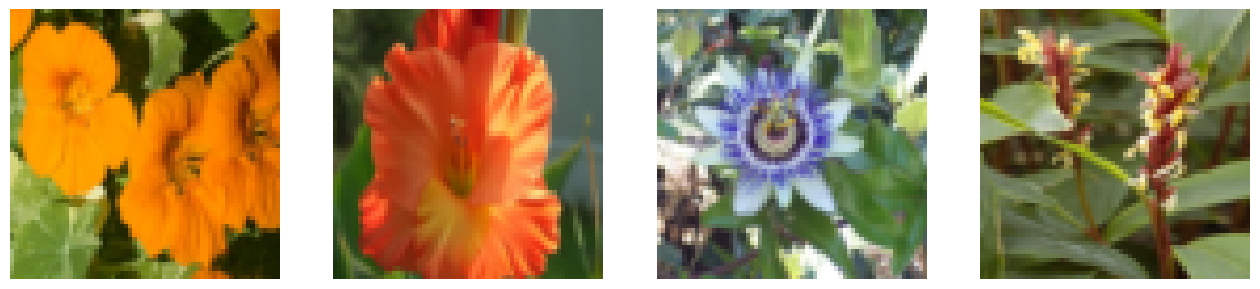

In [ ]:
import random
import matplotlib.pyplot as plt

num_samples = 4
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(num_samples):
    random_index = random.choice(range(dataset.shape[0]))
    axs[i].imshow(dataset[random_index]['images'].permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()

In [ ]:
import torch
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size,
                                         shuffle=True, drop_last = True)

In [ ]:
!pip install diffusers["torch"] transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


## 2. Подгрузим модель UNET

В модели укажем необходимые параметры. Она однозначно больше, чем та, что я собирала вручную.

К модели возьмем уже готовый scheduler и определим Loss

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
print(model)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0

In [ ]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)


print("Output shape:", model(sample_image, timestep=0).sample.shape)


Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])


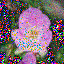

In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

## 3. Обучение и оценка

Подготовим функцию генерации для оценки, а также для обучения. Запусти обучение с помощью notebool_launcher.

In [ ]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import math
import os


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os





def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

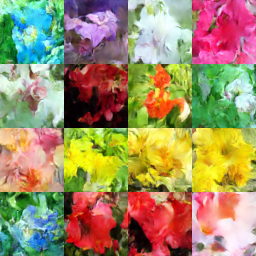

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Финальные выводы

Интересно, что кратинки получились более контрастные и яркие, чем от маленькой модели, но далекие все-таки от идеала. Больше похожи на аюстракцию, чем на цветы.

Поэтому, интересно приступить к следующей части и посмотреть, как справяться с генерацией stable diffusion models.